Max Contribution Ratio: 0.1 | Temps moyen perdu: 167.88 | Accuracy moyenne: 63.32%
Max Contribution Ratio: 0.2 | Temps moyen perdu: 60.48 | Accuracy moyenne: 75.11%
Max Contribution Ratio: 0.3 | Temps moyen perdu: 48.60 | Accuracy moyenne: 78.47%
Max Contribution Ratio: 0.4 | Temps moyen perdu: 46.26 | Accuracy moyenne: 78.50%
Max Contribution Ratio: 0.5 | Temps moyen perdu: 47.04 | Accuracy moyenne: 79.22%
Max Contribution Ratio: 0.6 | Temps moyen perdu: 45.50 | Accuracy moyenne: 78.69%
Max Contribution Ratio: 0.7 | Temps moyen perdu: 45.52 | Accuracy moyenne: 78.52%
Max Contribution Ratio: 0.8 | Temps moyen perdu: 45.76 | Accuracy moyenne: 79.51%
Max Contribution Ratio: 0.9 | Temps moyen perdu: 47.90 | Accuracy moyenne: 79.47%
Max Contribution Ratio: 1.0 | Temps moyen perdu: 43.12 | Accuracy moyenne: 79.70%


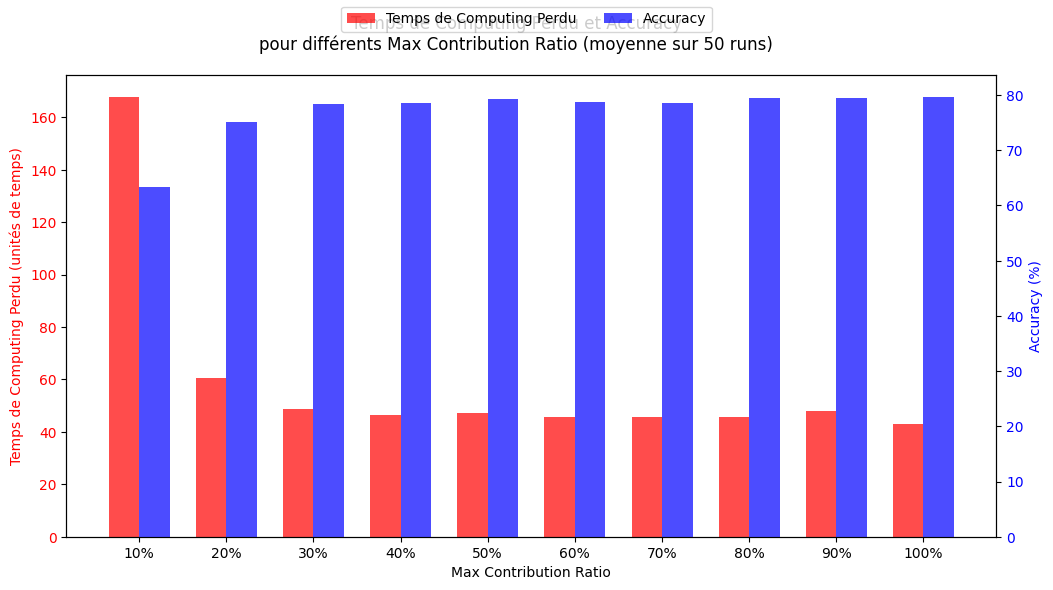

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt

def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged

def generate_dynamic_availability(total_time_steps, worker_id, num_workers, max_periods=5, min_processing_time=2):
    # On définit le centre de la simulation
    center = total_time_steps / 2
    # On fixe un offset maximum (par exemple total_time_steps / 8)
    max_offset = total_time_steps / 8
    # Calcul de l'offset pour chaque worker de façon symétrique
    if num_workers % 2 == 1:
        mid = (num_workers + 1) / 2
        offset = ((worker_id - mid) / mid) * max_offset
    else:
        mid = num_workers / 2
        offset = ((worker_id - mid - 0.5) / mid) * max_offset
    base_mean = center + offset
    # On ajoute un petit aléa pour éviter une régularité trop marquée
    mean = int(np.clip(base_mean + random.randint(-total_time_steps // 20, total_time_steps // 20), 0, total_time_steps - min_processing_time))
    std_dev = total_time_steps / 6
    availability_periods = []
    num_periods = random.randint(1, max_periods)
    for _ in range(num_periods):
        start_time = int(np.clip(np.random.normal(mean, std_dev), 0, total_time_steps - min_processing_time))
        duration = max(min_processing_time, int(np.abs(np.random.normal(3, 2))))
        end_time = min(start_time + duration, total_time_steps)
        if end_time - start_time >= min_processing_time:
            availability_periods.append((start_time, end_time))
    return merge_intervals(availability_periods)

# ------------------------------------------------------------------------------
# Définition du modèle de réseau de neurones
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ------------------------------------------------------------------------------
# Gestionnaire de mini-batches avec SubsetRandomSampler
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.sampler = SubsetRandomSampler(self.indices)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            random.shuffle(self.indices)
            self.sampler = SubsetRandomSampler(self.indices)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Classe Worker : gère le calcul local des gradients
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_id = None
    def is_available(self, current_time):
        for start_time, end_time in self.availability_periods:
            if start_time <= current_time < end_time:
                if self.finish_time is None or current_time >= self.finish_time:
                    return (current_time + self.processing_time) <= end_time
        return False
    def start_computation(self, current_time, batch_id, data, targets):
        if self.current_batch_id is None or self.current_batch_id != batch_id:
            self.current_batch_id = batch_id
            self.finish_time = current_time + self.processing_time
            # Pour la simulation expérimentale, on ne fait pas d'affichage ici
            return self.compute_gradient(data, targets)
        return None
    def has_finished(self, current_time):
        return self.finish_time == current_time
    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_id
    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)

# ------------------------------------------------------------------------------
# Serveur central : gère l'application des gradients
class Server:
    def __init__(self, dataset, batch_size=32, lr=0.001, max_contribution_ratio=0.5, verbose=True):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SimpleNN().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.current_batch = None
        self.current_batch_id = 0
        self.model_updated = True
        self.worker_contributions = {}
        self.wasted_gradients = {}       # Temps perdu par worker
        self.batch_send_times = {}       # Temps d'envoi de chaque batch
        self.total_wasted_time = 0
        self.max_contribution_ratio = max_contribution_ratio
        self.verbose = verbose

    def update_global_model(self, worker_gradients, batch_id, worker_id, current_time):
        # Vérification du ratio uniquement si la limite est < 1
        if self.max_contribution_ratio < 1:
            total_contrib = sum(self.worker_contributions.values()) if self.worker_contributions else 0
            if total_contrib > 0:
                worker_ratio = self.worker_contributions.get(worker_id, 0) / total_contrib
                if worker_ratio >= self.max_contribution_ratio:
                    send_time = self.batch_send_times.get(batch_id, current_time)
                    wasted = current_time - send_time
                    if self.verbose:
                        print(f"Worker {worker_id} a dépassé le seuil ({worker_ratio:.2f}). Gradient ignoré. Temps perdu: {wasted}")
                    self.wasted_gradients[worker_id] = self.wasted_gradients.get(worker_id, 0) + wasted
                    self.total_wasted_time += wasted
                    return

        if worker_gradients is None or batch_id != self.current_batch_id:
            send_time = self.batch_send_times.get(batch_id, current_time)
            wasted = current_time - send_time
            if self.verbose:
                print(f"Ignoré: Batch {batch_id} déjà traité pour Worker {worker_id}. Temps perdu: {wasted}")
            self.wasted_gradients[worker_id] = self.wasted_gradients.get(worker_id, 0) + wasted
            self.total_wasted_time += wasted
            return

        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = worker_gradients[name]
        self.optimizer.step()
        if self.verbose:
            print(f"Modèle mis à jour avec Batch {batch_id} grâce à Worker {worker_id}.")
        self.worker_contributions[worker_id] = self.worker_contributions.get(worker_id, 0) + 1
        self.model_updated = True

    def compute_wasted_computing_time(self):
        return self.total_wasted_time

    def print_worker_statistics(self):
        print("\nRésumé des contributions utiles des workers :")
        sorted_contrib = sorted(self.worker_contributions.items(), key=lambda x: x[1], reverse=True)
        for worker_id, count in sorted_contrib:
            print(f"Worker {worker_id} a contribué {count} fois.")
        print("\nRésumé des wasted computing (temps perdu) :")
        sorted_wasted = sorted(self.wasted_gradients.items(), key=lambda x: x[1], reverse=True)
        for worker_id, wasted_time in sorted_wasted:
            print(f"Worker {worker_id} a perdu {wasted_time} unités de temps.")
        wasted_time_total = self.compute_wasted_computing_time()
        print(f"\nTemps total de computing perdu : {wasted_time_total} unités de temps.")

    def get_batch_for_worker(self, current_time):
        if self.model_updated:
            self.current_batch = self.batch_manager.get_next_batch()
            self.current_batch_id += 1
            self.batch_send_times[self.current_batch_id] = current_time
            self.model_updated = False
        return self.current_batch, self.current_batch_id

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        return 100 * correct / total

    def plot_wasted_computing(self):
        if not self.wasted_gradients:
            if self.verbose:
                print("Aucun computing perdu à afficher.")
            return
        
        worker_ids = list(self.wasted_gradients.keys())
        wasted_times = list(self.wasted_gradients.values())
        plt.figure(figsize=(10, 6))
        plt.bar(worker_ids, wasted_times, color='red', alpha=0.7)
        plt.xlabel("ID du Worker")
        plt.ylabel("Unités de Temps de Computing Perdues")
        plt.title("Histogramme des Computing Perdus par Worker")
        plt.xticks(worker_ids)
        plt.yticks(np.arange(0, max(wasted_times)+1, step=1))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

# ------------------------------------------------------------------------------
# Simulation d'apprentissage fédéré (mode expérimental, sans affichage de plots intermédiaires)
class DiscreteEventSimulator:
    def __init__(self, server, workers, test_loader, total_time_steps=50):
        self.server = server
        self.workers = workers
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps
        self.global_time = 0
        self.worker_computing = []

    def plot_worker_availability(self):
        num_workers = len(self.workers)
        total_time_steps = self.total_time_steps
        availability_data = [(worker.worker_id, worker.availability_periods) for worker in self.workers]
        time_grid = np.zeros((num_workers, total_time_steps))
        for worker_id, periods in availability_data:
            for start, end in periods:
                time_grid[worker_id - 1, start:end] = 1
        plt.figure(figsize=(12, 6))
        plt.imshow(np.flipud(time_grid), aspect="auto", cmap="Blues", interpolation="nearest")
        plt.xlabel("Temps (Steps)")
        plt.ylabel("Workers")
        plt.title("Disponibilité des Travailleurs avant la Simulation")

        # Ajustement des ticks pour correspondre aux workers réels
        plt.xticks(range(0, total_time_steps, max(1, total_time_steps // 10)))
        plt.yticks(range(num_workers), [f"Worker {i}" for i in reversed(range(1, num_workers + 1))])

        plt.colorbar(label="Disponibilité (1 = Disponible, 0 = Indisponible)")
        plt.show()

        availability_counts = np.sum(time_grid, axis=0)
        mean_time = total_time_steps / 2
        std_dev_time = total_time_steps / 6
        x = np.arange(total_time_steps)
        normal_distribution = num_workers * (1 / (std_dev_time * np.sqrt(2 * np.pi))) * \
                              np.exp(-((x - mean_time) ** 2) / (2 * std_dev_time ** 2))
        plt.figure(figsize=(12, 6))
        plt.plot(x, availability_counts, marker='o', linestyle='-', label="Disponibilité totale réelle", color='blue')
        plt.plot(x, normal_distribution, linestyle='--', label="Approximation Normale", color='red')
        plt.xlabel("Temps (Steps)")
        plt.ylabel("Nombre de Travailleurs Disponibles")
        plt.title("Comparaison de la Disponibilité des Travailleurs avec une Loi Normale")
        plt.legend()
        plt.grid()
        plt.show()

    def run(self, verbose=False):
        #self.plot_worker_availability()
        for worker in self.workers:
            pass
            #print(f" Worker {worker.worker_id} disponible aux périodes {worker.availability_periods} | Temps de traitement : {worker.processing_time}")
        if verbose:
            print("Démarrage de la simulation...")
        while self.global_time < self.total_time_steps:
            if verbose:
                print(f"Temps {self.global_time}")
            # Fin des calculs terminés
            newly_finished_workers = [worker for worker in self.worker_computing if worker.has_finished(self.global_time)]
            for worker in newly_finished_workers:
                self.worker_computing.remove(worker)
                batch, _ = self.server.get_batch_for_worker(self.global_time)
                data, targets = batch
                gradients, batch_id = worker.compute_gradient(data, targets)
                self.server.update_global_model(gradients, batch_id, worker.worker_id, self.global_time)
            # Lancement des calculs pour les workers disponibles
            available_workers = [worker for worker in self.workers if worker.is_available(self.global_time) and worker not in self.worker_computing]
            for worker in available_workers:
                batch, batch_id = self.server.get_batch_for_worker(self.global_time)
                data, targets = batch
                worker.start_computation(self.global_time, batch_id, data, targets)
                self.worker_computing.append(worker)
            self.global_time += 1
        return self.server.compute_wasted_computing_time(), self.server.evaluate(self.test_loader)

# ------------------------------------------------------------------------------
# Fonction pour exécuter plusieurs runs d'expérience pour un max_contribution_ratio donné
def run_experiment(max_ratio, num_runs, total_time_steps, verbose=False):
    wasted_list = []
    accuracy_list = []
    
    # Chargement des données
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    for run in range(num_runs):
        # Réinitialisation du serveur avec le ratio spécifié
        server = Server(train_dataset, max_contribution_ratio=max_ratio, verbose=verbose)
        workers = []
        for i in range(1, 11):
            processing_time = random.randint(2, 4)
            # Utilisation de generate_dynamic_availability avec le worker_id
            availability = generate_dynamic_availability(288, worker_id=i,num_workers= 10, max_periods=5, min_processing_time=processing_time)
            workers.append(Worker(server.model, server.device, i, availability, processing_time))
        # Initialisation de la contribution de chaque worker dans le serveur
        for worker in workers:
            server.worker_contributions.setdefault(worker.worker_id, 0)
        
        simulator = DiscreteEventSimulator(server, workers, test_loader, total_time_steps=total_time_steps)
        wasted, acc = simulator.run(verbose=verbose)
        wasted_list.append(wasted)
        accuracy_list.append(acc)
    
    return np.mean(wasted_list), np.mean(accuracy_list)

# ------------------------------------------------------------------------------
# Expérience : tester différents max_contribution_ratio de 10% à 100% (0.1 à 1.0)
ratios = np.arange(0.1, 1.01, 0.1)
avg_wasted = []
avg_accuracy = []
num_runs = 50

for ratio in ratios:
    wasted, acc = run_experiment(max_ratio=ratio, num_runs=num_runs, total_time_steps=288, verbose=False)
    avg_wasted.append(wasted)
    avg_accuracy.append(acc)
    print(f"Max Contribution Ratio: {ratio:.1f} | Temps moyen perdu: {wasted:.2f} | Accuracy moyenne: {acc:.2f}%")

# ------------------------------------------------------------------------------
# Plot des résultats : double histogramme (groupé)
x = np.arange(len(ratios))  # positions sur l'axe x
width = 0.35  # largeur des barres

fig, ax1 = plt.subplots(figsize=(12, 6))

# Barres pour le temps de computing perdu
bars1 = ax1.bar(x - width/2, avg_wasted, width, label='Temps de Computing Perdu', color='red', alpha=0.7)
ax1.set_ylabel("Temps de Computing Perdu (unités de temps)", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(x)
ax1.set_xticklabels([f"{int(r*100)}%" for r in ratios])
ax1.set_xlabel("Max Contribution Ratio")

# Création d'un second axe pour l'accuracy
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, avg_accuracy, width, label='Accuracy', color='blue', alpha=0.7)
ax2.set_ylabel("Accuracy (%)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle("Temps de Computing Perdu et Accuracy\npour différents Max Contribution Ratio (moyenne sur 50 runs)")
fig.legend(loc="upper center", ncol=2)
plt.show()
